In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model

# Datasets

* The **Iris dataset** is a classic dataset popularized by Ronald Fisher, and widely available.

* The **climate dataset** is from the [UK Met Office](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/). Code for retrieving it from the Met Office website is given in the `climate.ipynb` notebook.

* The **stop-and-search dataset** is from the [UK Home Office](https://data.police.uk/api/). Code for retrieving it from the police website is given in the `stop-and-search.ipynb` notebook.

In [3]:
url = 'https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/iris.csv'
iris = pandas.read_csv(url)

In [4]:
url = 'https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/climate.csv'
climate = pandas.read_csv(url)
climate = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1985)].copy()
climate['t'] = climate.yyyy + (climate.mm-1)/12
climate['temp'] = (climate.tmin + climate.tmax)/2

In [5]:
# This dataset is large, and it's slow to download every time I run the notebook,
# so better to keep a local copy.
import os
if os.path.exists('stop-and-search.csv'):
    print("file already downloaded")
else:
    !wget "https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/stop-and-search.csv"

police = pandas.read_csv('stop-and-search.csv')

file already downloaded


# 2.1 Fitting a linear model

In [6]:
# Fit the model: Petal.Length = α + β * Sepal.Length + γ * Sepal.Length^2
# The features are One, SL, SL^2. We don't need to explicitly include One,
# because sklearn puts it in for us by default.

SL, PL = iris['Sepal.Length'], iris['Petal.Length']
model = sklearn.linear_model.LinearRegression()
model.fit(np.column_stack([SL, SL**2]), PL)
α,(β,γ) = model.intercept_, model.coef_
print(f'α={α:.3} β={β:.3} γ={γ:.3}')

# Make predictions at new values of SL.
newSL = np.linspace(4.2, 8.2, 20)
predPL = model.predict(np.column_stack([newSL, newSL**2]))

α=-17.4 β=5.39 γ=-0.296


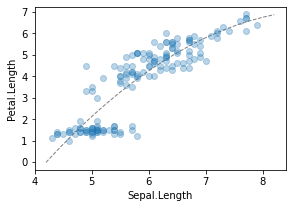

In [7]:
fig,ax = plt.subplots(figsize=(4.5,3))
ax.plot(newSL, predPL, color='0.5', zorder=-1, linewidth=1, linestyle='dashed')
ax.scatter(SL, PL, alpha=.3)
ax.set_ylabel('Petal.Length')
ax.set_xlabel('Sepal.Length')
plt.show()

# 2.2.1 One-hot features

In [8]:
# Hacky code, with hard-coded list of species 
species, SL, PL = iris['Species'], iris['Sepal.Length'], iris['Petal.Length']
species_levels = ['setosa','versicolor','virginica']
i1,i2,i3 = [np.where(species==k,1,0) for k in species_levels]
X = np.column_stack([i1, i2, i3, i1*SL, i2*SL, i3*SL])
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, PL)

LinearRegression(fit_intercept=False)

In [9]:
# Clean code, works for any number of species
species, SL, PL = iris['Species'], iris['Sepal.Length'], iris['Petal.Length']
species_levels = np.unique(species)
species_onehot = [np.where(species==k,1,0) for k in species_levels]
X = np.column_stack(species_onehot + [s*SL for s in species_onehot])
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, PL)

LinearRegression(fit_intercept=False)

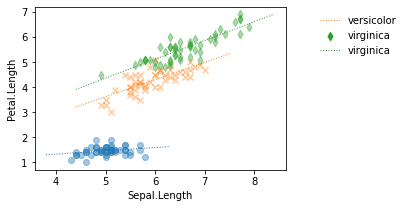

In [10]:
# Make predictions for each species, across a range of Sepal.Length
# This code tries to be clever, by not hard-coding either the number
# of species_levels nor the range of values at which we want to make
# predictions.

# First, get the range of Sepal.Length at which we want to plot the prediction,
# just slightly wider than the data range for each species
pred = (iris.groupby('Species')['Sepal.Length']
        .apply(lambda x: pandas.DataFrame({'Sepal.Length': np.linspace(min(x)-.5,max(x)+.5,20)}))
        .reset_index())

# Make predictions
new_onehot = [np.where(pred['Species']==k,1,0) for k in species_levels]
new_SL = pred['Sepal.Length']
new_X = np.column_stack(new_onehot + [s*new_SL for s in new_onehot])
pred['Petal.Length'] = model.predict(new_X)


# Matplotlib is ugly ...
fig,ax = plt.subplots(figsize=(4.5,3))
for k,m in zip(species_levels, ['o','x','d']):
    df = iris.loc[iris['Species'] == k]
    ax.scatter(df['Sepal.Length'], df['Petal.Length'], marker=m, label=k, alpha=0.4)
    df = pred.loc[pred['Species'] == k]
    ax.plot(df['Sepal.Length'], df['Petal.Length'], label=k, zorder=-1, linewidth=1, linestyle='dotted')

ax.set_ylabel('Petal.Length')
ax.set_xlabel('Sepal.Length')
        
h,l = ax.get_legend_handles_labels()
leg = plt.legend(h[3:], l[3:], loc=2, bbox_to_anchor=(1.1,1), frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()

## 2.2.2 Non-linear response

In [11]:
SL, PL = iris['Sepal.Length'], iris['Petal.Length']
newSL = np.linspace(1, 9, 100)

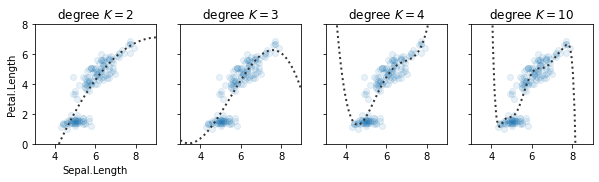

In [12]:
# Fit polynomials of various degrees
DEGREES = [2,3,4,10]

pred = []
for degree in DEGREES:
    model = sklearn.linear_model.LinearRegression()
    model.fit(np.column_stack([SL**d for d in range(1,degree+1)]), PL)
    newPL = model.predict(np.column_stack([newSL**d for d in range(1,degree+1)]))
    pred.append(pandas.DataFrame({'degree':degree, 'Sepal.Length':newSL, 'Petal.Length':newPL}))
pred = pandas.concat(pred)

fig,axs = plt.subplots(1, len(DEGREES), sharex=True, sharey=True, figsize=(10,2.2))
for ax,degree in zip(axs,DEGREES):
    ax.scatter(SL, PL, alpha=.1)
    df = pred.loc[pred.degree==degree]
    ax.plot(df['Sepal.Length'], df['Petal.Length'], zorder=10, label=f'k={degree}', color='0.2', linewidth=2, linestyle='dotted')
    ax.set_title(f'degree $K={degree}$')
axs[0].set_ylim(0,8)
axs[0].set_xlim(3,9)
axs[0].set_ylabel('Petal.Length')
axs[0].set_xlabel('Sepal.Length')
plt.show()

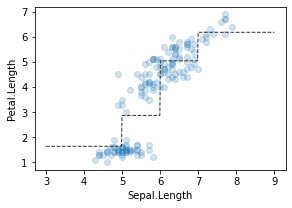

In [13]:
# Fit a step function

SLint = np.floor(SL).astype(np.int)
X = np.column_stack([SLint<=4, SLint==5, SLint==6, SLint>=7])
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, PL)

newSL = np.linspace(3,9,400)
newSLint = np.floor(newSL).astype(np.int)
newX = np.column_stack([newSLint<=4, newSLint==5, newSLint==6, newSLint>=7])
predPL = model.predict(newX)

fig,ax = plt.subplots(figsize=(4.5,3))
ax.plot(newSL, predPL, color='0.2', zorder=10, linewidth=1, linestyle='dashed')
ax.scatter(SL, PL, alpha=.2)
ax.set_ylabel('Petal.Length')
ax.set_xlabel('Sepal.Length')
plt.show()

# 2.2.3 Comparing groups

In [14]:
species, SL, PL = iris['Species'], iris['Sepal.Length'], iris['Petal.Length']

# Measure differences with respect to species='setosa'
species0 = 'setosa'
species_levels = ['versicolor', 'virginica']
X = np.column_stack([species==k for k in species_levels])
model = sklearn.linear_model.LinearRegression()
model.fit(X, PL)
α,(β_vers, β_virg) = model.intercept_, model.coef_

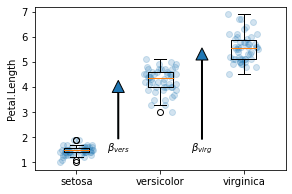

In [15]:
# For showing a scatter plot + box plot together, it's handy to convert
# species levels into integers. Matplotlib boxplot likes its indexes to start at 1.
speciesI = np.ones_like(species)
for i,k in enumerate(species_levels):
    speciesI[species==k] = i+2

fig,ax = plt.subplots(figsize=(4.5,3))
ax.scatter(speciesI + 0.2*np.random.uniform(low=-1,high=1,size=len(iris)), PL, alpha=.2)
ax.boxplot([PL[species==k] for k in [species0]+species_levels], labels=[species0]+species_levels)
ax.set_ylabel('Petal.Length')

plt.annotate('$β_{vers}$', xytext=(1.5,α), xy=(1.5,α+β_vers), ha='center', arrowprops={'width':1})
plt.annotate('$β_{virg}$', xytext=(2.5,α), xy=(2.5,α+β_virg), ha='center', arrowprops={'width':1})

plt.show()

# 2.2.4 Periodic patterns

In [16]:
t, temp = climate['t'], climate['temp']

π = np.pi
X = np.column_stack([np.sin(2*π*t), np.cos(2*π*t)])
model0 = sklearn.linear_model.LinearRegression()
model0.fit(X, temp)
α,(β1,β2) = model.intercept_, model.coef_

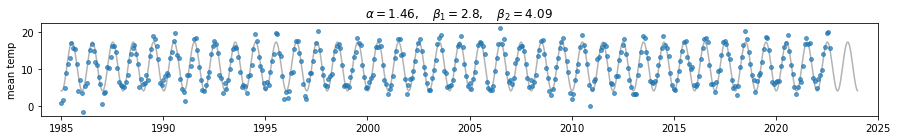

In [17]:
newt = np.linspace(1985, 2024, 1000)
pred = model0.predict(np.column_stack([np.sin(2*π*newt), np.cos(2*π*newt)]))

fig,ax = plt.subplots(figsize=(15,1.7))
ax.plot(newt, pred, color='0.7', zorder=0)
plt.scatter(t, temp, s=15, alpha=0.7)
plt.xlim(1984, 2025)
plt.title(f'$\\alpha={α:.3}, \\quad\\beta_1={β1:.3}, \\quad\\beta_2={β2:.3}$')
plt.ylabel('mean temp')
plt.show()

# 2.2.5 Secular trend

In [18]:
t, temp = climate['t'], climate['temp']

π = np.pi
X = np.column_stack([np.sin(2*π*t), np.cos(2*π*t), t])
modelA = sklearn.linear_model.LinearRegression()
modelA.fit(X, temp)
α,(β1,β2,γ) = modelA.intercept_, modelA.coef_

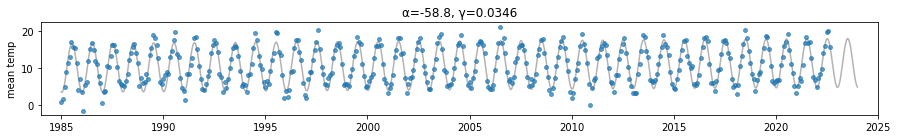

In [19]:
newt = np.linspace(1985, 2024, 1000)
pred = modelA.predict(np.column_stack([np.sin(2*π*newt), np.cos(2*π*newt), newt]))

fig,ax = plt.subplots(figsize=(15,1.7))
ax.plot(newt, pred, color='0.7', zorder=0)
plt.scatter(t, temp, s=15, alpha=0.7)
plt.xlim(1984, 2025)
plt.title(f'α={α:.3}, γ={γ:.3}')
plt.ylabel('mean temp')
plt.show()

# 2.3 Residuals plot

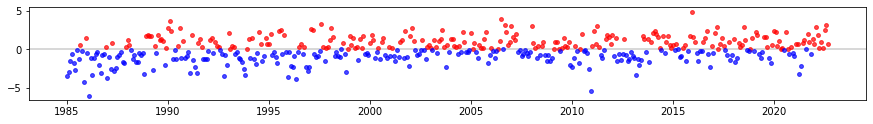

In [20]:
t, temp = climate['t'], climate['temp']

π = np.pi
X = np.column_stack([np.sin(2*π*t), np.cos(2*π*t)])
model0 = sklearn.linear_model.LinearRegression()
model0.fit(X, temp)

ε = temp - model0.predict(X)

fig,ax = plt.subplots(figsize=(15,1.7))
ax.axhline(0, color='0.8', zorder=-1)
ax.scatter(t[ε>0], ε[ε>0], color='red', s=15, alpha=0.7)
ax.scatter(t[ε<=0], ε[ε<=0], color='blue', s=15, alpha=0.7)

plt.show()

# 2.6 Interpreting coefficients
## Intercept for climate model

In [21]:
t, temp = climate['t'], climate['temp']

π = np.pi
model0 = sklearn.linear_model.LinearRegression()
model0.fit(np.column_stack([np.sin(2*π*t), np.cos(2*π*t)]), temp)

modelA = sklearn.linear_model.LinearRegression()
modelA.fit(np.column_stack([np.sin(2*π*t), np.cos(2*π*t), t]), temp)

modelB = sklearn.linear_model.LinearRegression()
modelB.fit(np.column_stack([np.sin(2*π*t), np.cos(2*π*t), t-2000]), temp)

for m,lbl in [(model0,'0'), (modelA,'A'), (modelB,'B')]:
    print(f'Model {lbl}: α={m.intercept_:.3}')

Model 0: α=10.6
Model A: α=-58.8
Model B: α=10.5


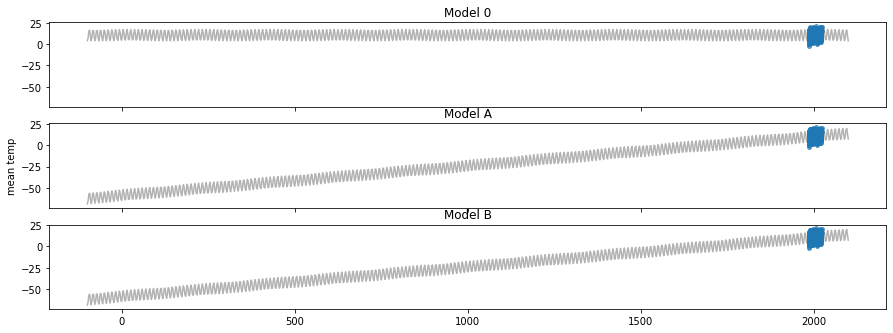

In [22]:
newt = np.linspace(-100, 2100, 1000)
pred0 = model0.predict(np.column_stack([np.sin(2*π*newt), np.cos(2*π*newt)]))
predA = modelA.predict(np.column_stack([np.sin(2*π*newt), np.cos(2*π*newt), newt]))
predB = modelB.predict(np.column_stack([np.sin(2*π*newt), np.cos(2*π*newt), newt-2000]))

fig,(ax0,axA,axB) = plt.subplots(3,1, figsize=(15,3.1*1.7), sharex=True, sharey=True)
for ax,pred,lbl in [(ax0,pred0,'0'),(axA,predA,'A'),(axB,predB,'B')]:
    ax.plot(newt, pred, color='0.7', zorder=0)
    ax.scatter(t, temp, s=15, alpha=0.7)
    ax.set_title(f'Model {lbl}')
axA.set_ylabel('mean temp')
plt.show()

## Racial bias in stop-and-search data?

In [23]:
# Only keep rows where ethnicity is valid, and outcome isn't blank.
ethnicity_levels = ['Asian','Black','Mixed','Other','White']
ok = police['officer_defined_ethnicity'].isin(ethnicity_levels) & (police['outcome']!='')
eth = police.loc[ok, 'officer_defined_ethnicity']
y = np.where(police.loc[ok, 'outcome']=='False', 0, 1)

In [24]:
# Model with confounded features

eth_onehot = [np.where(eth==k,1,0) for k in ethnicity_levels]
model = sklearn.linear_model.LinearRegression()
model.fit(np.column_stack(eth_onehot), y)
α,βs = model.intercept_, model.coef_

print(f'α = {α}')
for k,β in zip(ethnicity_levels, βs):
    print(f'β[{k}] = {β}')

α = -252707409745.33115
β[Asian] = 252707409746.11566
β[Black] = 252707409746.0951
β[Mixed] = 252707409746.24744
β[Other] = 252707409746.10062
β[White] = 252707409746.09003


In [25]:
# Model with linearly independent features
# These features are set up so that:
# α is the average response for eth==Asian
# β[k] is (response for eth==k) - (response for eth==Asian)

some_levels = [k for k in ethnicity_levels if k != 'Asian']
eth_onehot = [np.where(eth==k,1,0) for k in some_levels]
model = sklearn.linear_model.LinearRegression()
model.fit(np.column_stack(eth_onehot), y)
α,βs = model.intercept_, model.coef_

print(f'α = {α}')
for k,β in zip(ethnicity_levels, βs):
    print(f'β[{k}] = {β}')

α = 0.784879741495949
β[Asian] = -0.021411332597936598
β[Black] = 0.13361174268896583
β[Mixed] = -0.014553588092374082
β[Other] = -0.025912142018683415
